<a href="https://colab.research.google.com/github/RenanNB360/OCR_em_Videos_com_EAST_Tesseract_EasyOCR/blob/main/OCR_em_v%C3%ADdeos_com_EAST%2C_Tesseract_e_EasyOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações

In [1]:
import cv2
import os
import imutils
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image
from PIL import ImageFont, ImageDraw, Image
from matplotlib import pyplot as plt
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow

# Conectando com o Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!cp /content/drive/MyDrive/2025-vision/files/eng.traineddata /content/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [4]:
import pytesseract

In [5]:
tessdata_dir = os.path.abspath('/content/')
os.environ['TESSDATA_PREFIX'] = tessdata_dir

In [6]:
config_tesseract = f'{tessdata_dir} --psm 7'

In [7]:
def tesseract(img, config_tesseract):
  text = pytesseract.image_to_string(img, lang='eng', config=config_tesseract)
  return text

# Pré-Processamento

In [8]:
def pre_processing(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  maior = cv2.resize(gray, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
  valor, otsu = cv2.threshold(maior, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  return otsu

# Configuração do EAST

In [9]:
!cp /content/drive/MyDrive/2025-vision/files/frozen_east_text_detection.pb /content/

In [10]:
detector = 'frozen_east_text_detection.pb'
width_EAST, height_EAST = 640, 640

In [11]:
min_conf_EAST = 0.9

In [12]:
layers_EAST = [
    'feature_fusion/Conv_7/Sigmoid',
    'feature_fusion/concat_3'
]

# Funções EAST

In [13]:
def data_geometric(geometry, y):
  x0_data = geometry[0, 0, y]
  x1_data = geometry[0, 1, y]
  x2_data = geometry[0, 2, y]
  x3_data = geometry[0, 3, y]
  data_angles = geometry[0, 4, y]
  return x0_data, x1_data, x2_data, x3_data, data_angles

In [14]:
def geometric_calculus(x0, x1, x2, x3, data_angle, x, y):
  (offsetX, offsetY) = (x * 4.0, y * 4.0)
  angle = data_angle[x]
  cos = np.cos(angle)
  sin = np.sin(angle)
  h = x0[x] + x2[x]
  w = x1[x] + x3[x]

  endX = int(offsetX + (cos * x1[x]) + (sin * x2[x]))
  endY = int(offsetY - (sin * x1[x]) + (cos * x2[x]))

  startX = int(endX - w)
  startY = int(endY - h)

  return startX, startY, endX, endY

# Função para o Processamento da Imagem

In [15]:
def EAST_processing(img, width, height, net, layers, min_conf):
  original = img.copy()
  (H, W) = img.shape[:2]

  proportion_W = W / float(width)
  proportion_H = H / float(height)

  img = cv2.resize(img, (width, height))
  (H, W) = img.shape[:2]

  blob = cv2.dnn.blobFromImage(img, 1.0, (W, H), swapRB=True, crop=False)

  net.setInput(blob)
  (scores, geometry) = net.forward(layers)

  (lines, columns) = scores.shape[2:4]

  boxes = []
  confidence_boxes = []

  for y in range(0, lines):
    scores_data = scores[0, 0, y]
    x0, x1, x2, x3, data_angles = data_geometric(geometry, y)

    for x in range(0, columns):
      if scores_data[x] < min_conf:
        continue

      startX, startY, endX, endY = geometric_calculus(x0, x1, x2, x3, data_angles, x, y)
      confidence_boxes.append(scores_data[x])
      boxes.append((startX, startY, endX, endY))

  return boxes, confidence_boxes, proportion_H, proportion_W

# Função para Escrita no Vídeo

In [16]:
font = '/content/drive/MyDrive/2025-vision/files/calibri.ttf'

In [17]:
def write_text(text, x, y, img, font, color=(50, 50, 255), size=22):
  img_pil = Image.fromarray(img)
  draw = ImageDraw.Draw(img_pil)
  font = ImageFont.truetype(font, size)
  draw.text((x, y-size), text, font=font, fill=color)
  img= np.array(img_pil)

  return img

In [18]:
def bottom_text(text, x, y, img, font, color=(200, 255, 0), size=32):
  bottom = np.full((img.shape), (0,0,0), dtype=np.uint8)
  text_bottom = write_text(text, x, y, bottom, font, (255,255,255), size=size)
  text_bottom = cv2.dilate(text_bottom, (np.ones((3,5),np.uint8)))
  fx, fy, fw, fh = cv2.boundingRect(text_bottom[:,:,2])
  cv2.rectangle(img, (fx, fy), (fx + fw, fy + fh), color, -1)

  return img

# Carrega o Modelo EAST

In [19]:
EAST_net = cv2.dnn.readNet(detector)

# Carregamento do Vídeo

In [20]:
files_video = '/content/drive/MyDrive/2025-vision/files/test02.webm'
cap = cv2.VideoCapture(files_video)
connected, video = cap.read()
print(connected, video)

True [[[18 26 50]
  [18 26 50]
  [18 24 53]
  ...
  [15 18 36]
  [15 18 36]
  [14 18 34]]

 [[18 26 50]
  [18 26 50]
  [18 24 53]
  ...
  [15 18 36]
  [15 18 36]
  [14 18 34]]

 [[18 26 50]
  [18 26 50]
  [18 24 53]
  ...
  [15 18 36]
  [15 18 36]
  [14 18 34]]

 ...

 [[16 22 51]
  [18 24 53]
  [17 22 54]
  ...
  [14 18 34]
  [14 18 34]
  [14 19 32]]

 [[16 22 51]
  [18 24 53]
  [17 22 54]
  ...
  [14 18 34]
  [14 18 34]
  [14 19 32]]

 [[16 22 51]
  [18 24 53]
  [17 22 54]
  ...
  [14 18 34]
  [14 18 34]
  [14 19 32]]]


In [21]:
video.shape

(198, 325, 3)

In [22]:
video_width = video.shape[1]
video_height = video.shape[0]

# Redimensionar o Tamanho do Vídeo

In [23]:
def resize_video(video_width, video_height, max_width=320):
  if video_width > max_width:
    proportion = video_width / video_height
    width = max_width
    height = int(width / proportion)
  else:
    width = video_width
    height = video_height
  return width, height

In [24]:
video_width, video_height = resize_video(video.shape[1], video.shape[0], 320)
video_width, video_height

(320, 194)

# Definindo as Configurações do Vídeo

In [25]:
name_file = '/content/drive/MyDrive/2025-vision/files/result.avi'

In [26]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')

In [27]:
fps = 24

In [28]:
output_video = cv2.VideoWriter(name_file, fourcc, fps, (video_width, video_height))

# Definindo as Variáveis

In [29]:
samples_display = 50
samples_current = 0

In [30]:
margin = 4

# Processamento do Vídeo e Exibição do Resultado

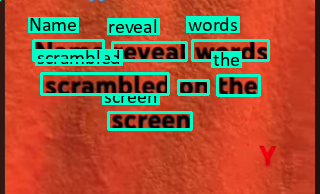

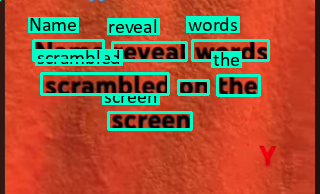

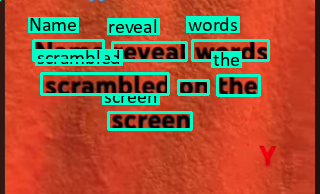

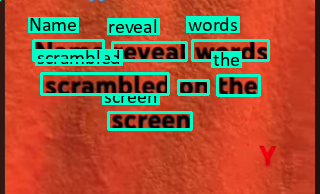

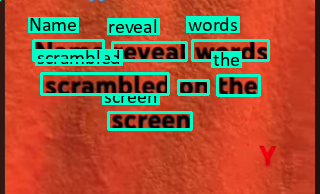

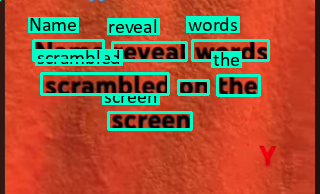

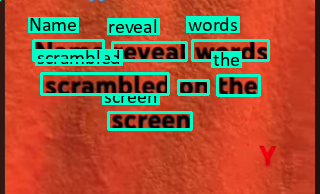

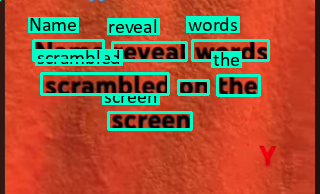

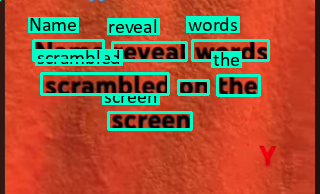

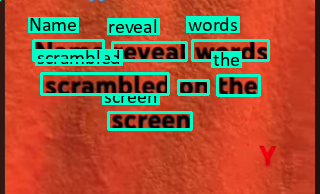

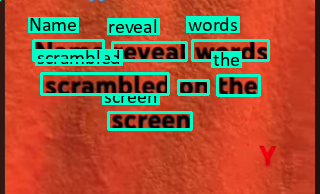

Finished


In [31]:
while (cv2.waitKey(1) < 0):
  connected, frame = cap.read()

  if not connected:
    break

  frame = cv2.resize(frame, (video_width, video_height))

  image_cp = frame.copy()

  boxes, confidence, proportion_H, proportion_W  = EAST_processing(frame, width_EAST, height_EAST, EAST_net, layers_EAST, min_conf_EAST)
  detections = non_max_suppression(np.array(boxes), probs=confidence)
  for (startX, startY, endX, endY) in detections:
    startX = int(startX * proportion_W)
    startY = int(startY * proportion_H)
    endX = int(endX * proportion_W)
    endY = int(endY * proportion_H)

    cv2.rectangle(frame, (startX, startY), (endX, endY), (200, 255, 0), 2)

    h, w = image_cp.shape[:2]
    startY = max(0, startY - margin)
    endY   = min(h, endY + margin)
    startX = max(0, startX - margin)
    endX   = min(w, endX + margin)

    roi = image_cp[startY:endY, startX:endX]

    if roi is None or roi.size == 0:
      print(f"Região vazia: startY={startY}, endY={endY}, startX={startX}, endX={endX}")
      continue

    img_process = pre_processing(roi)
    text = tesseract(img_process, config_tesseract)
    text = ''.join([c if ord(c) < 128 else '' for c in text]).strip()
    frame = bottom_text(text, startX, startY, frame, font, (200,255,0), 20)
    frame = write_text(text, startX, startY, frame, font, (0,0,0), 20)

  if samples_current <= samples_display:
    cv2_imshow(frame)
    samples_current += 1

  output_video.write(frame)

print('Finished')
output_video.release()

# OCR com EasyOCR

In [33]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [57]:
from easyocr import Reader
import cv2
from google.colab.patches import cv2_imshow
from PIL import ImageFont, ImageDraw, Image
import numpy as np

In [58]:
languages_list = 'en,pt'
languages = languages_list.split(',')
print(languages)

['en', 'pt']


In [59]:
font = '/content/drive/MyDrive/2025-vision/files/calibri.ttf'
gpu = True

In [60]:
file_video = '/content/drive/MyDrive/2025-vision/files/test01.webm'
cap = cv2.VideoCapture(file_video)

connected, video = cap.read()
video_width = video.shape[1]
video_height = video.shape[0]

In [61]:
video_width, video_height = resize_video(video.shape[1], video.shape[0], 320)
print(video_width, video_height)

320 194


In [62]:
def coord_box(box):
  (te, td, bd, be) = box
  te = (int(te[0]), int(te[1]))
  td = (int(td[0]), int(td[1]))
  bd = (int(bd[0]), int(bd[1]))
  be = (int(be[0]), int(be[1]))
  return te, td, bd, be

In [63]:
def draw_box(img, te, bd, color_box=(200,255,0), thickness=2):
  cv2.rectangle(img, te, bd, color_box, thickness)
  return img

In [64]:
file_name = '/content/drive/MyDrive/2025-vision/files/result_easyocr.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24
output_video = cv2.VideoWriter(file_name, fourcc, fps, (video_width, video_height))

In [65]:
samples_display = 50
sample_current = 0

In [66]:
color_font = (0,0,0)
color_bottom = (200,255,0)
color_box = (200,255,0)
size_font = 20

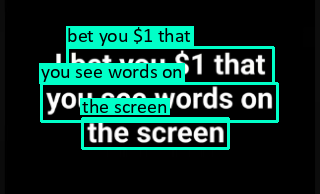

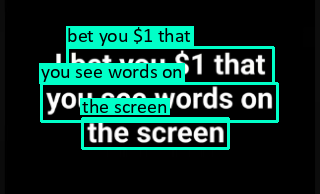

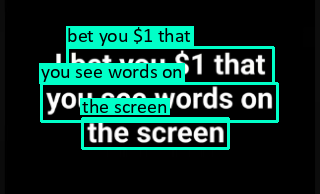

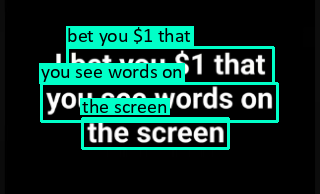

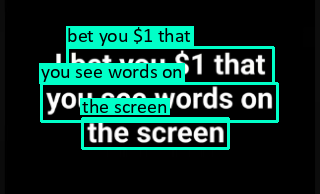

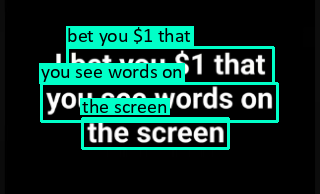

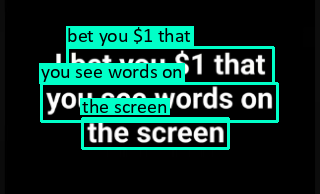

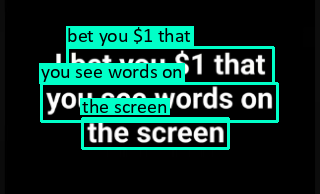

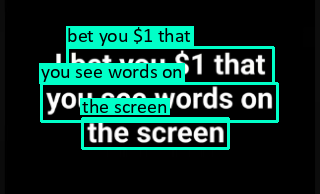

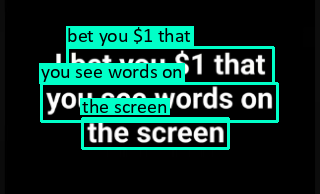

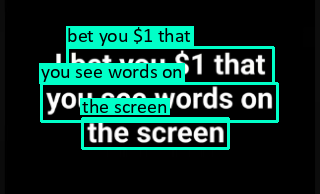

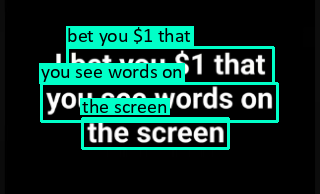

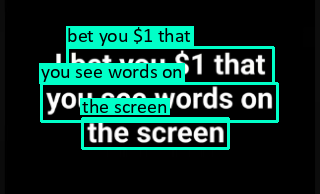

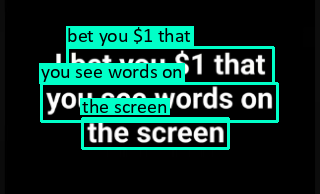

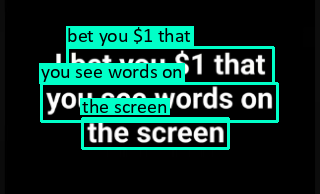

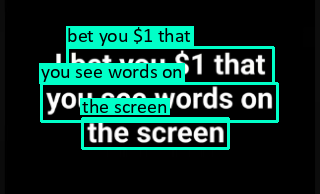

Finished


In [67]:
while (cv2.waitKey(1) < 0):
  connected, frame = cap.read()

  if not connected:
    break

  frame = cv2.resize(frame, (video_width, video_height))
  image_cp = frame.copy()

  reader = Reader(languages, gpu=gpu)
  results = reader.readtext(frame)

  for (box, text, prob) in results:
    te, td, bd, be = coord_box(box)

    frame = draw_box(frame, te, bd)
    frame = bottom_text(text, te[0], te[1], frame, font, color_bottom, size_font)
    frame = write_text(text, te[0], te[1], frame, font, color_font, size_font)

  if sample_current <= samples_display:
    cv2_imshow(frame)
    sample_current += 1

  output_video.write(frame)

print('Finished')
output_video.release()